In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0
!pip install transformers
# !pip install transformers==4.8.0
!pip install transformers sentencepiece
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 831.4 MB 2.4 kB/s 
     |████████████████████████████████| 22.1 MB 1.1 MB/s 
     |████████████████████████████████| 1.9 MB 57.1 MB/s 
     |████████████████████████████████| 7.6 MB 55.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
     

In [ ]:
import gc
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import gc
import json,torch,time,pickle
import matplotlib.pyplot as plt 
from pathlib import Path
from transformers import BertTokenizer,AutoTokenizer,AdamW,AutoModelForQuestionAnswering,BertTokenizerFast
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# !nvidia-smi

In [ ]:
def read_squad(path):
    # se abre el archivo JSON y cargue el diccionario de introducción
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    # inicializar listas para contextos, preguntas y respuestas // título, pregunta, respuesta, resumen (contextos)
    contexts = []
    questions = []
    answers = []
    # itera a través de todos los datos 
    for i in squad_dict["data"]:
        try:
            for x in i['paragraphs'][0]['qas']:
              for xx in x['answers']:
                # print(x)
                context = i['paragraphs'][0]['context']
                question = x['question']
                answer = xx
            # comprueba si necesitamos extraer de 'answers' o 'plausible_answers'
            if 'plausible_answers' in i.keys():
                access = 'plausible_answers'
            else:
                access = 'answers'
            # agregar datos a listas // título, pregunta, respuesta, resumen
            contexts.append(context)
            questions.append(question)
            answers.append(answer)
        except:
            print("error")
    # devolver listas de datos 
    return contexts, questions, answers

# train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/Colab Notebooks/Ajuste_Pytorch/CopiaDatosEntrenamiento.json')
# val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/Colab Notebooks/Ajuste_Pytorch/DatosEntrenamiento.json')
train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/Colab Notebooks/Ajuste_Pytorch/answers.json')
val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/Colab Notebooks/Ajuste_Pytorch/COVID-QA_Answers_Validacion.json')

In [ ]:
# print(train_contexts[0])
# print(train_questions[0])
# print(train_answers[0])

def add_end_idx(answers, contexts):
    # se recorre cada par respuesta-contexto
    for answer, context in zip(answers, contexts):
        # gold_text se refiere a la respuesta que esperamos encontrar en contexto
        gold_text = answer['text']
        # se conoce el índice de inicio
        start_idx = answer['answer_start']
        # idealmente este sería el índice final
        end_idx = start_idx + len(gold_text)
        
        # A veces las respuestas se desvían por un caracter o dos
        if context[start_idx:end_idx] == gold_text:
            # si la respuesta no es apagada
            answer['answer_end'] = end_idx
        else:
            print(gold_text)
            # esto significa que la respuesta está desviada por 1-2 tokens
            for n in [1, 2]:
                if context[start_idx - n:end_idx - n] == gold_text:
                    answer['answer_start'] = start_idx - n
                    answer['answer_end'] = end_idx - n
    # print(cont)
    
# y se aplica la función a nuestras dos listas de respuestas
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
max_length = 384 # La longitud máxima de cadena (pregunta y contexto)
doc_stride = 128 # La cantidad que se solapará entre dos partes del contexto si es necesario

In [ ]:
# print(train_answers[:5])
from transformers import BertTokenizerFast
# inicializar el tokenizador
tokenizer = BertTokenizerFast.from_pretrained("deepset/bert-base-cased-squad2")
# tokenizador
train_encodings = tokenizer( train_contexts, train_questions, max_length=max_length, padding = True, truncation= True, stride=doc_stride)
val_encodings = tokenizer(val_contexts, val_questions, max_length=max_length, padding = True, truncation= True, stride=doc_stride)
# print(tokenizer.decode(train_encodings['input_ids'][0]))


In [ ]:

def add_token_positions(encodings, answers):
    # se inicializa las listas para contener los índices de token de inicio / final de respuesta
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        print(answers[i]['answer_start'])
        print(answers[i]['text'])
        # agregar la posición del token de inicio/final usando el método char_to_token
        print(answers[i])
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))
        # si la posición inicial es None, el pasaje de respuesta se ha truncado
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        # si no se encuentra la posición final , se emplea char_to_token y cambiará la posición hasta encontrarla
        shift = 1
        while end_positions[-1] is None:
            # print(answers[i]['answer_end'])
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - shift)
            shift += 1
    # Actualiza encodings con las nuevas posiciones de inicio/final basadas en tokens.
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

# Se aplica la funcion a los datos
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

13
the virus can survive for 24-72 hours on surfaces, depending on the type of surface
{'answer_id': 560239, 'document_id': 976964, 'question_id': 457700, 'text': 'the virus can survive for 24-72 hours on surfaces, depending on the type of surface', 'answer_start': 13, 'answer_end': 96, 'answer_category': None}
0
The virus can survive on surfaces for up to 72 hours such as plastic and stainless steel
{'answer_id': 560238, 'document_id': 976962, 'question_id': 457699, 'text': 'The virus can survive on surfaces for up to 72 hours such as plastic and stainless steel', 'answer_start': 0, 'answer_end': 88, 'answer_category': None}
194
4-8 hours taken with RT-PCR
{'answer_id': 560246, 'document_id': 977009, 'question_id': 457707, 'text': '4-8 hours taken with RT-PCR', 'answer_start': 194, 'answer_end': 221, 'answer_category': None}
12
therapy with mAbs and the drug remdesivir could be an ideal therapeutic option for COVID-19
{'answer_id': 560249, 'document_id': 977026, 'question_id': 457710,

In [ ]:
import torch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

In [ ]:
#Entrenamiento
from transformers import BertTokenizerFast, BertForQuestionAnswering
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers.optimization import Adafactor
from tqdm import tqdm
gc.collect()
torch.cuda.empty_cache()
model_path = "deepset/bert-base-cased-squad2"

model = BertForQuestionAnswering.from_pretrained(model_path).to(device)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [ ]:
from torch.utils.data import DataLoader

def eval_loader(batch_size=7,dump_equals=False):
    dump_equals=False
    model.eval()
    acc = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dump_count = 0
    eval_data = []
    for batch in train_loader:
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            # realiza estimaciones
            outputs = model(input_ids, attention_mask=attention_mask)
            # obtien la mejor predicción con argmax
            start_pred = torch.argmax(outputs['start_logits'], dim=1)
            end_pred = torch.argmax(outputs['end_logits'], dim=1)
            # calcula la precisión 
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())     
            
            eval_data.append([start_pred , start_true,end_pred , end_true])

            if dump_equals and dump_count < 14 and start_pred == start_true and end_pred == end_true:
              dump_count += 1
              tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'][0])
              pred = get_text_atrange(  tokens,start_pred[0],end_pred[0] )
              print("tokens",pred )
              print("start_pred == start_true",start_pred , start_true)
              print("end_pred == end_true",end_pred , end_true)
              print("--") 
    # calcula de la precisión total, promediando las precisiones
    acc = sum(acc)/len(acc)
    print("Precisión del modelo ajustado:", acc)
    print("eval_data", eval_data)
    return acc ,eval_data

In [ ]:
from time import time
import matplotlib.pyplot as plt

def plot_eval(eval_data):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(11, 8)
  axes[0].set_title("Predicción")
  axes[1].set_title("Real")
  axes[2].set_title("Combinado")
  for index,e_data in enumerate(eval_data):
    start_pred , end_pred =  e_data[0] , e_data[2]
    start_true , end_true =  e_data[1] , e_data[3]
    
    if abs(start_true - end_true) < 100:
      axes[0].plot([index,index],[start_pred.cpu().numpy(), end_pred.cpu().numpy()],color="blue",linestyle='-')
      axes[1].plot([index,index],[start_true.cpu().numpy(), end_true.cpu().numpy()],color="orange")  

      axes[2].plot([index*2,index*2],[start_pred.cpu().numpy(), end_pred.cpu().numpy()],color="blue",linestyle='-')
      axes[2].plot([index*2+1,index*2+1],[start_true.cpu().numpy(), end_true.cpu().numpy()],color="orange")  
      
  fig.tight_layout()

In [ ]:
acc,eval_data = eval_loader(1,dump_equals=False)


Precisión del modelo ajustado: 0.03115727002967359
eval_data [[tensor([0], device='cuda:0'), tensor([36], device='cuda:0'), tensor([0], device='cuda:0'), tensor([39], device='cuda:0')], [tensor([18], device='cuda:0'), tensor([18], device='cuda:0'), tensor([0], device='cuda:0'), tensor([29], device='cuda:0')], [tensor([0], device='cuda:0'), tensor([7], device='cuda:0'), tensor([0], device='cuda:0'), tensor([34], device='cuda:0')], [tensor([71], device='cuda:0'), tensor([66], device='cuda:0'), tensor([80], device='cuda:0'), tensor([81], device='cuda:0')], [tensor([0], device='cuda:0'), tensor([9], device='cuda:0'), tensor([0], device='cuda:0'), tensor([21], device='cuda:0')], [tensor([0], device='cuda:0'), tensor([155], device='cuda:0'), tensor([0], device='cuda:0'), tensor([161], device='cuda:0')], [tensor([0], device='cuda:0'), tensor([512], device='cuda:0'), tensor([0], device='cuda:0'), tensor([32], device='cuda:0')], [tensor([0], device='cuda:0'), tensor([1], device='cuda:0'), tenso

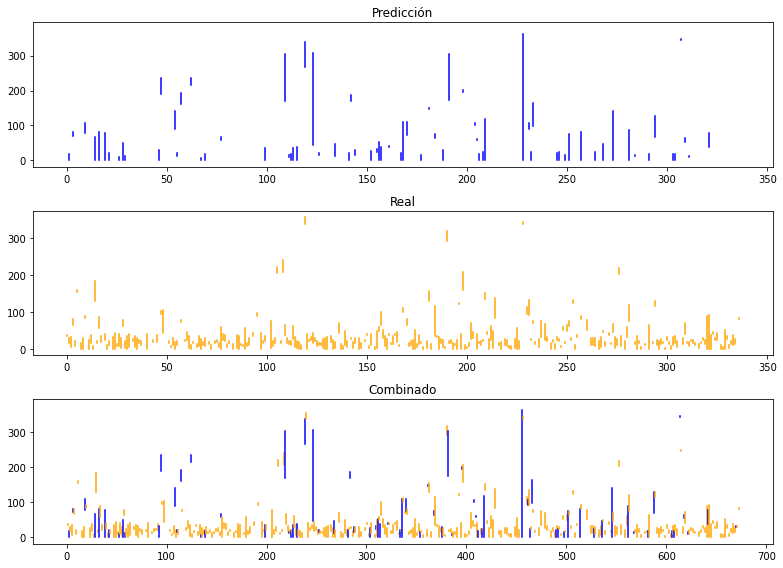

In [ ]:
plot_eval(eval_data)
